In [2]:
using CSV
using DataFrames
using PyPlot
using Statistics
using Random
using LaTeXStrings

# (optional) check out all of the styles! https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("Solarize_Light2")

# (optional)change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

16

watch this [hilarious video](https://fivethirtyeight.com/features/not-even-scientists-can-easily-explain-p-values/) where scientists are asked to explain the p-value in one sentence. challenge yourself to explain a p-value in one sentence after going through this notebook.

# A/B testing

> In modern data analytics, deciding whether two numerical samples come from the same underlying distribution is called A/B testing. The name refers to the labels of the two samples, A and B. [source](https://www.inferentialthinking.com/chapters/12/1/AB_Testing.html)

how many cauliflowers are allocated to each group?

In [3]:
df = CSV.read("cauliflower.csv", copycols=true)
first(df, 6)

,group,mass
,String,Float64
1,control,905.204
2,fertilizer,910.038
3,fertilizer,892.856
4,control,828.234
5,control,715.818
6,fertilizer,701.48


compare the distribution of masses among the two groups (control, treatment) in two ways:
* two opaque histograms on top of each other
* two box plots next to each other

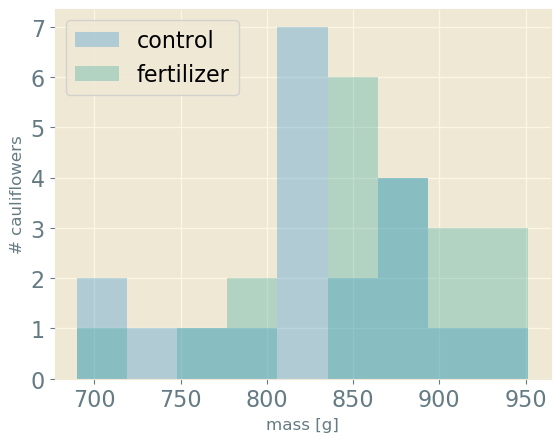

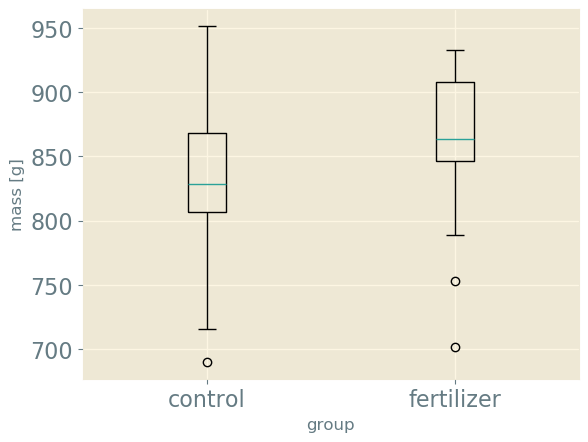

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


PyObject Text(25.0, 0.5, 'mass [g]')

In [4]:
###
# (1) two histograms
#do not manually make bins, it will silently cut out data
bins = range(minimum(df[:, :mass]), stop=maximum(df[:, :mass]), length=10) # shared bins

figure()
for df_g in groupby(df, :group) #groupby loops over the different groups 
    groub = df_g[1, :group]
    hist(df_g[:, :mass], label=groub, alpha=0.3, bins=bins)
end
legend()
xlabel("mass [g]")
ylabel("# cauliflowers")
show()

###
# (2) two boxplots
groups = ["control", "fertilizer"]
figure()
boxplot([filter(cauli -> cauli[:group] == group, df)[:, :mass] for group in groups]) #this is an array of 2 arrays 

xticks([1, 2], groups) #relabels x markings
xlabel("group")
ylabel("mass [g]")

the distribution of masses of cauliflowers in the fertilizer group appears to be biased to the right of the distribution of masses of cauliflowers in the control group.

the average cauliflower mass in the fertilizer group is greater than the average mass in the control group.

In [5]:
by(df, :group, avg_mass=:mass => mean) #pass data frame, what to look in, new column name, 
#what to look at in each and what function to apply to it

,group,avg_mass
,String,Float64
1,control,827.462
2,fertilizer,859.655


**this difference in means could be due to chance, owing to the random process of allocating the cauliflowers to the control and treatment groups!** 

                         #distribution refers to the whole population 
**null hypothesis**: The distribution of masses amoung cauli's treated with fertilizer is identical to that of those in the control group. 
**alternative hypothesis**: The distribution of masses amoung cauli's treated with fertilizer is diffrent from those in the control group 

*test statistic* := (mean mass of cauli's in fertilizer group) - (mean mass of cauli's in control group) #if null is true this is zero 

this test statistic is a random variable. if we could repeat the cauliflower experiment over and over...


## compute the test statistic
first, write a function that computes the mean mass of cauliflowers falling in a particular group ("control" or "fertilizer").

then, write a function that computes the difference in means between the two groups.

In [9]:
function μ_mass(df_cauli::DataFrame, group_col_name::Symbol, group::String)
    df_group = (filter(cauli->cauli[group_col_name] == group, df_cauli))
    #V2
        #df_means = by(df_cauli, group_col_name, avg_mass=:mass=>mean)
    #V3 one line
        # resturn mean((filter(cauli->cauli[group_col_name] == group, df_cauli))[:, :mass])
    return mean(df_group[:, :mass])
end

#DO THIS WHILE WRITING FUNCTIONS!!
#pretend we are inside the function. we'd be given these: 
    #df_cauli = deepcopy(df) #actually makes a new variable with this information 
    #group_col_name = :group 
    #group = "control"

#make dataframe of caulis from only this group 
    #df_this_group = filter(cauli -> cauli[group_col_name] == group, df_cauli)
    #mean(df_this_group[:, :mass])
#μ_mass(df, :group, "control")
#df2 = deepcopy(df)

μ_mass (generic function with 1 method)

In [10]:
for group in ["control", "fertilizer"]
    println("{mass $group cauli}= ", μ_mass(df, :group, group))
end

{mass control cauli}= 827.4623135088772
{mass fertilizer cauli}= 859.655362579846


In [15]:
"""our test statistic"""

function difference_in_means(df_cauli::DataFrame, group_col_name::Symbol) 
    
    return (μ_mass(df_cauli, group_col_name, "fertilizer" ))-(μ_mass(df, group_col_name, "control"))
end 

actual_difference_in_means = difference_in_means(df, :group)

32.19304907096887

## randomly permuting the group labels: simulating the test statistic under the null hypothesis
how do we simulate a repetition of this random experiment and obtain its test statistic (= difference in mean masses between fertilized and control cauli's) under the null hypothesis?


In [20]:
#mass stays the same because we are assuming that the null is true 
df[!, :shuffled_group] = shuffle(df[:, :group])
first(df, 6)



,group,mass,shuffled_group
,String,Float64,String
1,control,905.204,control
2,fertilizer,910.038,control
3,fertilizer,892.856,control
4,control,828.234,control
5,control,715.818,fertilizer
6,fertilizer,701.48,fertilizer


indeed, the test statistic is different (unless we happen to assing the cauliflowers to the same group, which is very unlikely).

In [21]:
new_test_statistics = difference_in_means(df, :shuffled_group)

3.247157650075337

## obtain the distribution of the test statistic under the null hypothesis

let us now simulate repititions of the random experiment under the null hypothesis 10000 times, record the difference in means among the two groups, then plot the distribution of the difference in means 

In [25]:
nb_sims = 10000
#pre allocate space!!!
differences_in_means= [NaN for s =1:nb_sims]
for s = 1:nb_sims
    #suffle group labels
    df[!, :shuffled_group] = shuffle(df[:, :group])
    #compute the test statistic under this simulation (under the null hypothesis)
    #store it in an array 
    differences_in_means[s] = difference_in_means(df, :shuffled_group)
    
end

differences_in_means

10000-element Array{Float64,1}:
   2.529155574995798 
  18.075387350464894 
   9.899980396196042 
 -29.418425689190258 
   1.2775030207673126
  20.06811584838306  
 -38.3337005466218   
   0.8548047993677983
   9.400097576331405 
 -24.21614375328579  
  24.27632906375038  
 -21.111449412261777 
 -55.19779531650704  
   ⋮                 
  10.739190761127361 
 -14.649434814122856 
  12.757481707148145 
  -7.136994243099252 
  40.49786574577945  
 -16.35873717509628  
   9.635312420020455 
  16.856650459214848 
 -16.370189334187558 
  24.032517562390126 
 -11.171366341384783 
  14.50515312540449  

now plot the distribution of the difference of means under the null hypothesis

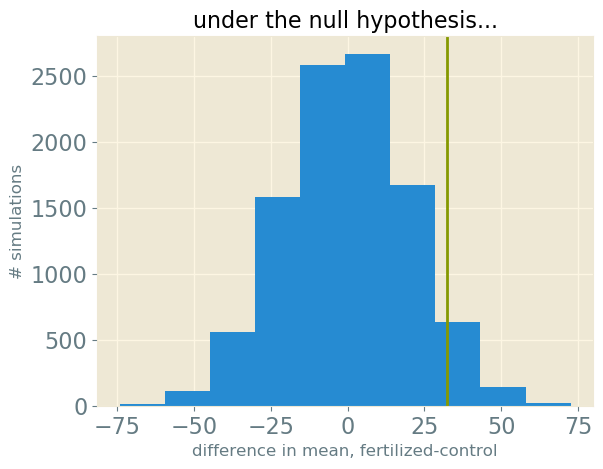

([10.0, 115.0, 562.0, 1584.0, 2584.0, 2670.0, 1675.0, 637.0, 145.0, 18.0], [-74.21996879118592, -59.539890446827556, -44.859812102469185, -30.179733758110814, -15.49965541375245, -0.8195770693940858, 13.860501274964292, 28.540579619322656, 43.22065796368102, 57.9007363080394, 72.58081465239775], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x0000000001C00400>, PyObject <matplotlib.patches.Rectangle object at 0x0000000001BF1F28>, PyObject <matplotlib.patches.Rectangle object at 0x0000000001C00940>, PyObject <matplotlib.patches.Rectangle object at 0x0000000001C00C50>, PyObject <matplotlib.patches.Rectangle object at 0x0000000001C00F60>, PyObject <matplotlib.patches.Rectangle object at 0x0000000001C0C2B0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000001C0C5C0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000001C0C8D0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000001C0CBE0>, PyObject <matplotlib.patches.Rectangle object at 0x000000

In [27]:
figure() 
xlabel("difference in mean, fertilized-control")
ylabel("# simulations")
title("under the null hypothesis...")
axvline(x=actual_difference_in_means, c ="C2")
hist(differences_in_means)

#p-value is just the percentage of times that the results are greater than the mean 
#i.e (the number of times to the right of the line over the total amount)

why is the difference in means centered around zero? because, under the null hypothesis, there is no difference in the mean mass between the control and treatment groups!

## compare distribution of test statistic to our observed test statistic, compute p-value



In [29]:
#this says that there is a 5% chance that this is due to random chance 
p_value = sum(differences_in_means .> actual_difference_in_means) / nb_sims


0.0558

the **p-value** is the proportion of simulated experiments under the null hypothesis where the difference in means was equal to or more extreme than what we observed in the actual experiment.

In [ ]:
p_value = 